# OFDM

Frekvencijski multipleks ortogonalnih podnosilaca (engl. *Orthogonal Frequency Division Multiplexing*, OFDM) tehnika je paralelnog prijenosa podataka koja odvaja dostupni spektar na određeni broj podnosilaca kojima se prijenos vrši.

OFDM signal nastaje kada modulacijski signal (OFDM simbol) modulira sinusni prijenosni signal. Pojednostavljeni prikaz vidljiv je na donjoj slici.

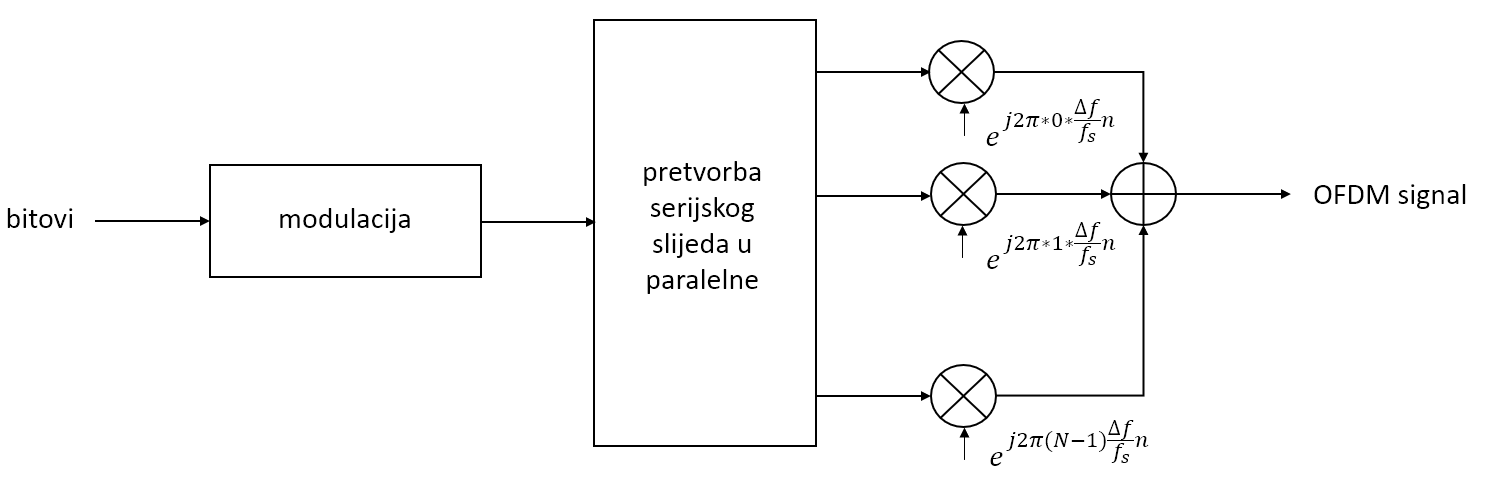





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

In [ ]:
# pomocna funkcija - konstelacijski dijagram
def scatterplot(x, y, ax=None):
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()
    ax.scatter(x,y)
    ax.set_title('konstelacijski dijagram')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')
    return ax

In [ ]:
# pomocna funkcija - dijagram u frekvencijskoj domeni
def frequency_plot(freqs, signal_db, ax=None):
    if ax is None:
        ax = plt.gca()
    plt.plot(freqs, signal_db)
    plt.ylim(bottom=-20)
    plt.title('podnosioci - spektar')
    plt.xlabel('f [Hz]')
    plt.ylabel('PSD [dB]')
    return ax

In [ ]:
# pomocna funkcija - izracun spektralne gustoce snage koristenjem usrednjavanja periodograma

def psd(sig,nfft,wtype,overlap):

    if (wtype != 'Hamming') and (wtype != 'Bartlett') \
        and (wtype != 'Blackman') and (wtype != 'Hann')\
        and (wtype != 'Rectangle'):

        raise Exception('Window must be: Hamming, Bartlett, Blackman, Hann or Rectangle.')

    if (overlap < 0) or (overlap > 1):

        raise Exception('Overlap ratio must be between 0 and 1.')

    if wtype == 'Hamming':
        window = signal.windows.hamming(nfft,0)
    elif wtype == 'Bartlett':
        window = signal.windows.bartlett(nfft,0)
    elif wtype ==  'Blackman':
        window = signal.windows.blackman(nfft,0)
    elif wtype ==  'Hann':
        window = signal.windows.hann(nfft,0)
    elif wtype == 'Rectangle':
        window = signal.windows.boxcar(nfft)

    noverlap = math.floor(nfft*overlap)

    length = sig.size
    num_fft = (length - noverlap) // (nfft - noverlap)

    pgram_vec = np.zeros(num_fft*nfft)
    j = 0
    k = 0

    for i in range(num_fft):

        pgram_vec[j:j+nfft] = np.abs(np.fft.fft(sig[k:k+nfft],nfft) * window) ** 2

        j = j + nfft
        k = k + (nfft - noverlap)

    pgram_res = pgram_vec.reshape(num_fft,nfft)

    psd_est = np.sum(pgram_res,0,np.float64)/num_fft

    return psd_est

U OFDM-u, serijski tok podataka velike brzine dijeli se na paralelne tokove manje brzine. $N$ je broj podnosilaca koji će paralelno prenositi podatke. $N$ je izabran tako da je, nakon podjele ukupnog dostupnog frekencijskog pojasa, frekvencijski odziv kanala približno konstantan u pojasu podnosioca.

OFDM podnosioci moduliraju se najčešće pomoću BPSK modulacijskog postupka ili QAM postupaka različite složenosti. Brzina prijenosa OFDM simbola jednaka je frekvenciji uzorkovanja OFDM sustava ($f_s$). $Δf$ razmak je između podnosilaca. Korisno vrijeme trajanja simbola na svakom od paralelenih podnosilaca *(još ne razmatramo ciklički prefiks)* je $T$ pa je upravo zbog paralelnosti i trajanje OFDM simbola jednako $T$.

In [ ]:
modulation_scheme = 'BPSK'
fs = 40e6
N = 128
delta_f = fs/N
print(delta_f)
T = 1/delta_f

312500.0


Zadatak 1.

a) Čime je određen razmak $Δf$ u OFDM-u? Što takav razmak omogućuje? Zašto je to svojstvo korisno?

b) Koliko u ovom primjeru iznosi $Δf$?

<font color='green'>Razmak između podnosilaca u OFDMu određen je ukupnom širinom frekvencijskog pojasa i broja podnosilaca, odnosno jednak je recipročnoj vrijednosti ukupnog trajanja moduliranog signala u potkanalu tj. intervala ortogonalnosti. Upravo ovo omogućuje svojstvo ortogonalnosti kod QAM i BPSK modulacija, odnosno pravokutnih signala u vremenskoj domeni. Takvi signali u frekvencijskoj domeni predstavljeni su ovojnicom funkcije sinc(x), čije nultočke se nalaze upravo u višekretnicima $1/T_0$.

$Δf$ iznosi 312500Hz
</font>

U OFDM sustavu, ulazni bitovi formiraju modulirane simbole sukladno odgovarajućoj modulacijskoj shemi (ovdje BPSK postupkom). Podatkovni bitovi u ovom će primjeru biti generirani slučajno.

In [ ]:
def symbol_generator(nsym, modulation_scheme):
  if modulation_scheme == 'BPSK':
        m = 1  # bit po simbolu
        M = 2 ** m # broj simbola u shemi

        bpsk = [-1+0j, 1+0j] #vrijednosti simbola

        ints = np.random.randint(0,M,nsym)

        data = [bpsk[i] for i in ints]
        data = np.array(data,np.complex64)

  elif modulation_scheme == 'QAM-16':
        m = 4  # bit po simbolu
        M = 2 ** m  # broj simbola u shemi

        qam16 = [-3 - 3j, -3 - 1j, -3 + 3j, -3 + 1j,
                 -1 - 3j, -1 - 1j, -1 + 3j, -1 + 1j,
                 3 - 3j, 3 - 1j, 3 + 3j, 3 + 1j,
                 1 - 3j, 1 - 1j, 1 + 3j, 1 + 1j]

        ints = np.random.randint(0, M, nsym)

        data = [qam16[i] for i in ints]
        data = np.array(data, np.complex64)

        # just for test
        plt.scatter(np.real(data), np.imag(data), marker='o')
        plt.grid(True)
        plt.show()

  return data

Izabire se broj OFDM simbola koji želimo generirati ($n_{ofdm}$). Svaki OFDM simbol sastoji se od sume $N$ paralelnih podatkovnih simbola koji moduliraju različite podnosioce. Kako bi se svi podatci rasporedili u željeni broj OFDM simbola, potrebno je $N*n_{OFDM}$ podatkovnih simbola nastalih moduliranjem ulaznih bitova.

<Axes: title={'center': 'konstelacijski dijagram'}, xlabel='I', ylabel='Q'>

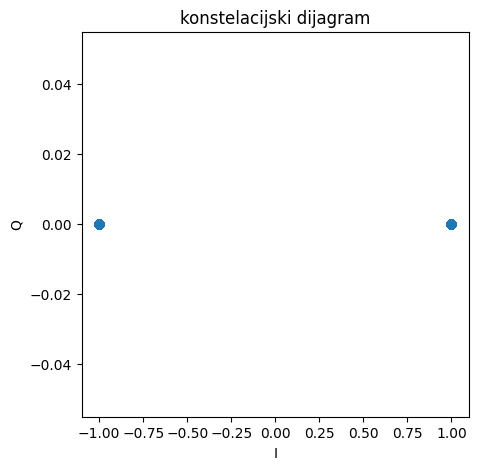

In [ ]:
n_ofdm = 100 # proizvoljno zadano
nsym = n_ofdm * N

data_ser = symbol_generator(nsym, modulation_scheme)

scatterplot(data_ser.real,data_ser.imag,ax=None)


Sada se serijski slijed podataka pretvara u paralelne.

In [ ]:
data_par = np.zeros((N,n_ofdm),np.complex64)
j= 0

for i in range(n_ofdm):
    data_par[:,i] = data_ser[j:j+N]
    j = j + N

U realnim sustavima ne koriste se svi podnosioci za podatkovni prijenos. U OFDM simbol ugrađuju se pilotski podnosioci. Također, podnosioci najbliže rubovima često se postavljaju u nulu.

Zadatak 2.

a) Čemu služe pilotski podnosioci?

b) Zašto se podnosioci najbliže rubovima postavljaju u nulu?


<font color='green'>Piotski podnosioci omogućavaju ekvalizaciju, postupak korekcije nejednakosti u kanalu koje mogu uzrokovati promjene u amplitudi i fazi signala tijekom prijenosa. Pomoću pilotskih podnosioca izračunavamo prijenosnu karakteristiku kanala, koju interpolacijom primjenjujemo na druge kanale.

Korištenje zero-paddinga u OFDMu ima nominalno zaštitnu svrhu. Podnositelji na početku i na kraju OFDM simbola nemaju energiju kako bi se smanjilo preklapanje simbola i međusobna interferencija. Posebno nakon postupaka modulacije i demodulacije gdje ovakva praksa smanjuje izobličenja.
</font>

Zbog jednostavnosti, u vježbi će se pretpostaviti da se svi podnosioci koriste za podatkovni prijenos.

In [ ]:
subc = np.zeros((N,N),np.complex64) # matrica podnosilaca
k = np.arange(N) # indeksi
n = np.arange(N)

for i in range(N):
    subc[i,:] = np.exp(1j*2*math.pi*k[i]*(delta_f/fs)*n)

subc_modul = np.zeros((N,n_ofdm*N),np.complex64)

j = 0

for i in range(n_ofdm):
    subc_modul[:,j:j+N] = subc * data_par[:,i][:, np.newaxis]
    j = j + N

Nakon moduliranja podnosilaca, proučit će se njihov spektar.  

<Axes: title={'center': 'podnosioci - spektar'}, xlabel='f [Hz]', ylabel='PSD [dB]'>

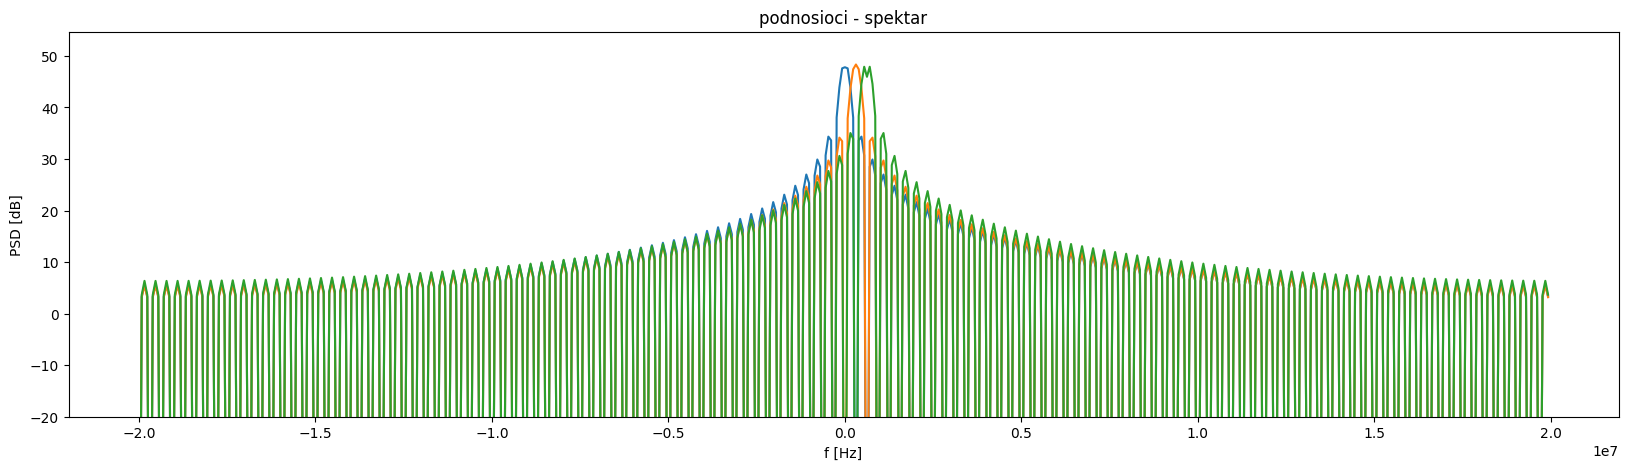

In [ ]:
# uzimanje triju podnosilaca
sc_1 = subc_modul[0,:]
sc_2 = subc_modul[1,:]
sc_3 = subc_modul[2,:]

# procjena spektralne gustoce snage podnosilaca
fft_s = 512
wtype = 'Rectangle'
overlap = 0
psd_est_1 = psd(sc_1,fft_s,wtype,overlap)
psd_est_2 = psd(sc_2,fft_s,wtype,overlap)
psd_est_3 = psd(sc_3,fft_s,wtype,overlap)

epsilon = 1e-9; # da bi se sprijecilo dijeljenje s nulom
psd_db_1 = 10 * np.log10(psd_est_1+epsilon)
psd_db_2 = 10 * np.log10(psd_est_2+epsilon)
psd_db_3 = 10 * np.log10(psd_est_3+epsilon)

freqs = np.linspace(-fs/2,(fs/2 - (fs/fft_s)), fft_s)


fig=plt.figure(figsize=(20,5), dpi=100)
frequency_plot(freqs, np.fft.fftshift(psd_db_1), ax=None)
frequency_plot(freqs, np.fft.fftshift(psd_db_2), ax=None)
frequency_plot(freqs, np.fft.fftshift(psd_db_3), ax=None)

Zadatak 3.

a) Koji je oblik frekvencijskog spektra pojedinog podnosioca? Po čemu je to moguće zaključiti?

b) Je li oblik u ovom primjeru idealan i zašto? Bi li to u realnom prijemniku uopće bilo važno?

Napomena: po potrebi smanjiti broj promatranih podnosilaca zbog jasnijeg opažanja.

<font color='green'>
Svaki podnosilac predstavljen je sinc(x) funkcijom u frekvencijskoj domeni jer koristimo BPSK modulaciju čiji simbol u vremenskoj domeni je predstavljen pravokutnim signalom. Dodatno, vidimo iz grafa ako se fokusiramo na samo jedan subcarrier. Nepreciznost ovog prikaza je uvjetovana (ne)preciznošću FFT-a, a ona sampling frequencyem. U realnom prijamniku ne bi bilo važno, dapače, teško je u potpunosti izbjeći spectral leakage u realnom svijetu, a on je rezultat i same hardverske implementacije, ne samo IFFTa koji se u prijamniku dešava.
</font>

U stvarnosti dolazi do pomaka maksimuma podnosilaca od njihovih idealnih frekvencija pa je izražena interferencija među nosiocima koja se iskazuje kao aditivni šum.

Zadatak 4.

Nadopuniti funkciju ***symbol_generator*** da ima opciju moduliranja bitova 16-QAM postupkom. Nacrtati konstelacijski dijagram.

Napomena: u nastavku (nakon 4. zadatka) potrebno je raditi s BPSK moduliranim podatcima. Ako za ovaj zadatak mijenjate kod na način da mijenjate vrijednosti već postojećih varijabli, nakon crtanja konstelacijskog dijagrama 16-QAM postupka potrebno je vratiti podatke za BPSK postupak. Druga je opcija definirati varijable drugačijeg naziva za 16-QAM postupak i kasnije ih više ne pozivati.

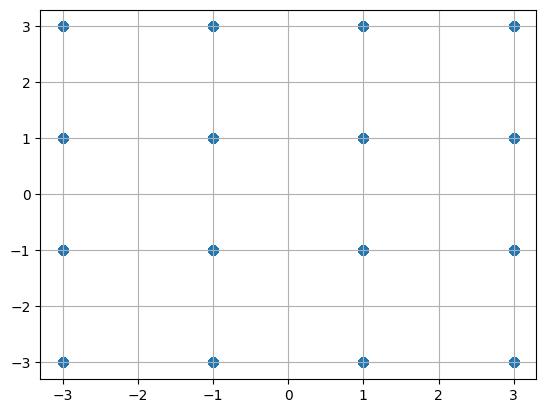

array([-3.-3.j, -3.+1.j,  3.+3.j, ...,  3.-3.j, -1.+1.j, -3.-1.j],
      dtype=complex64)

In [ ]:
#symbol_generator funkcija nadopunjena je tamo gdje treba

symbol_generator(nsym, "QAM-16")

Potrebno je zbrojiti dobivene modulirane podnosioce (OFDM simbole) kako bi se dobio konačni OFDM signal.

In [ ]:
ofdm_sum = np.sum(subc_modul,0,np.complex64)/N

### IFFT i FFT

Dosad razmatrani OFDM proces zahtijeva $N$ kompleksnih oscilatora na odašiljaču i prijemniku. To je problem zbog složenosti i cijene. Efikasnost izvođenja povećava se ako se OFDM simboli moduliraju IFFT-om.

In [ ]:
def ifft_modul(symbols,N):
    ofdm_data = np.fft.ifft(symbols,N)
    return ofdm_data

ofdm_ifft = np.zeros(n_ofdm*N,np.complex64)

j = 0

for i in range(n_ofdm):
    ofdm_ifft[j:j+N] = ifft_modul(data_ser[j:j+N],N)
    j = j + N


Zadatak 5.

Napisati kod za crtanje usporebe OFDM signala generiranog zbrajanjem podnosilaca bez direktne uporabe ifft naredbe ($ofdm_{sum}$) i onog dobivenog IFFT-om ($ofdm_{ifft}$). Napomena: razdvojiti realni i imaginarni dio! (Inače će se javiti upozorenje: *Casting complex values to real discards the imaginary part.*)

Pripaziti da crtež bude pregledan. Uputa: prikazati manji broj elemenata OFDM signala.

Što je moguće zaključiti?

Text(0.5, 1.0, 'Imaginarne vrijednosti')

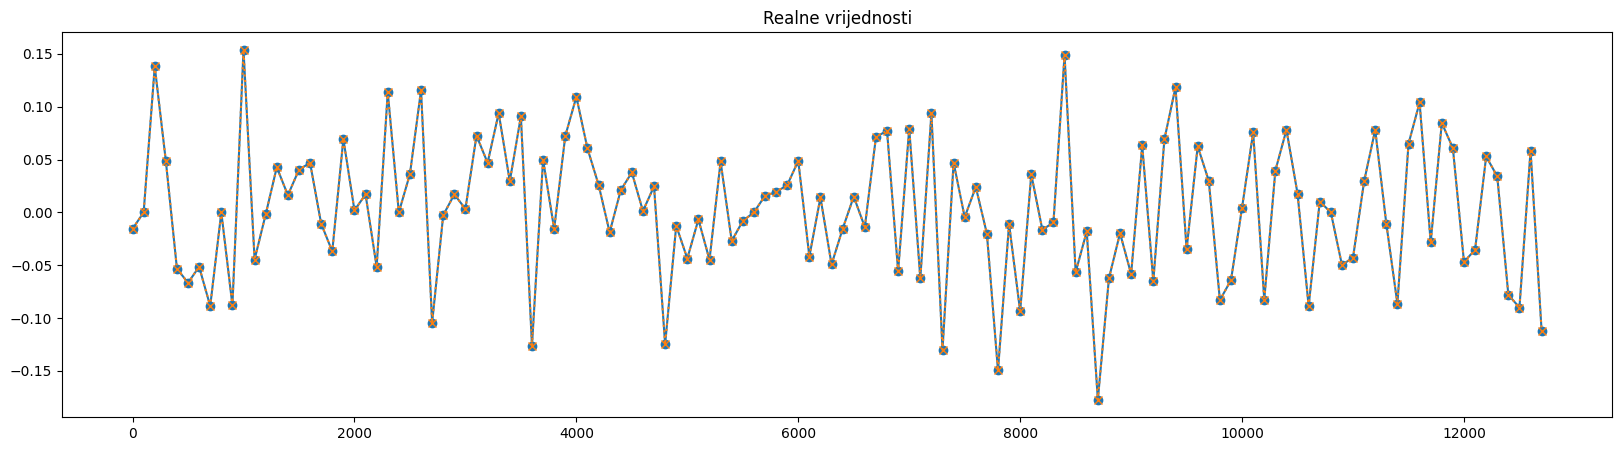

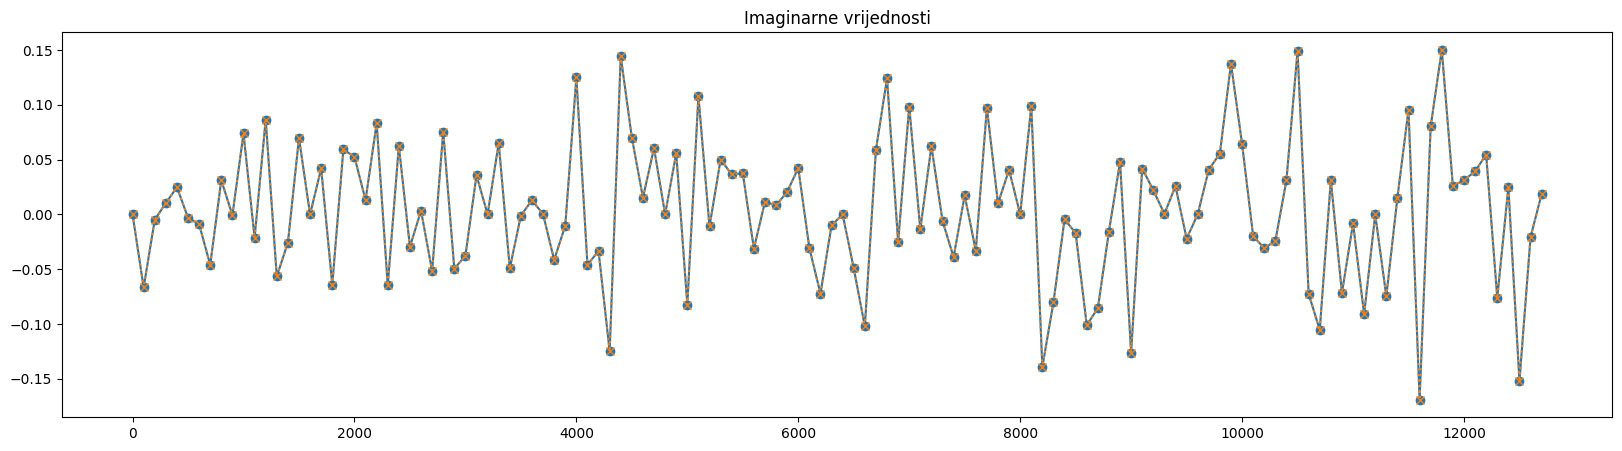

In [45]:
fig=plt.figure(figsize=(20,5), dpi=100)
plt.plot(range(0, 12800, 100), np.real(ofdm_sum[::100]), marker='o', linestyle='-')
plt.plot(range(0, 12800, 100), np.real(ofdm_ifft[::100]), marker='x', linestyle='dotted')
plt.title("Realne vrijednosti")

fig=plt.figure(figsize=(20,5), dpi=100)
plt.plot(range(0, 12800, 100), np.imag(ofdm_sum[::100]), marker='o', linestyle='-')
plt.plot(range(0, 12800, 100), np.imag(ofdm_ifft[::100]), marker='x', linestyle='dotted')
plt.title("Imaginarne vrijednosti")

### Višestazno prostiranje

U prostoru bez prepreka, prijemnik bi primio oslabljenu i zakašnjelu repliku odaslana signala. Ipak, uz prisustvo prepreka, prijemni signal zbroj je zakašnjelih replika odaslana signala s različitim amplitudama, fazama i kašnjenjem. Kanal je određen vremenskom razlikom u pristizanju prve i posljednje replike različitih staza (engl. *delay spread*). Veličina inverzna tome vremenu širina je kanala unutar koje je karakteristika kanala približno konstanta - koherencijski pojas (engl. *coherence bandwidth*). Ideja OFDM-a je pretvoriti širokopojasni kanal u mnogo uskopojasnih kako bi se smanjila intersimbolna interferencija. Prema tome, širina svakog podnosioca manja je od koherencijskog pojasa.

Kanal s višestaznim prostiranjem može se modelirati filtrom s konačnim impulsnim odzivom (engl. *Finite Impulse Response*, FIR). Izlazni signal jednak je konvoluciji ulaznog signala i impulsnog odziva kanala. Koeficijenti filtra predstavljaju različite višestazne komponente, a duljina filtra određena je vremenskom razlikom u pristizanju prve i posljednje replike različitih višestaznih komponenti.

Primjer FIR filtra (s $N$ koeficijenata/koraka) prikazan je na slici (izvor: Wikipedia):

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/FIR_Filter.svg" width="
700"/>
</div>

OFDM simbol bit će predstavljen jednim podnosiocem (i jednom od dvaju kompleksnih komponenata) zbog jednostavnosti prikaza utjecaja filtriranja.

Text(0, 0.5, 'amplituda')

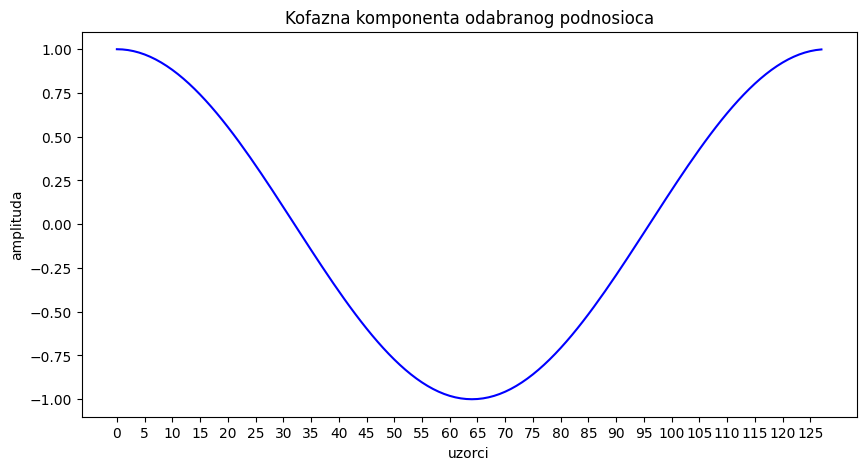

In [ ]:
n = np.arange(N)
k = 1
sc = np.exp(1j*2*math.pi*k*n/N)

# potrebno je odabrati realnu ili imaginarnu komponentu podnosioca;
# prikaz ce biti intuitivniji ako se promatra realna komponenta

subc_real = sc.real

fig=plt.figure(figsize=(10,5), dpi=100)
plt.plot(subc_real,'b')
plt.title('Kofazna komponenta odabranog podnosioca')
plt.xticks(np.arange((0), len(subc_real)+1, 5.0))
plt.xlabel('uzorci')
plt.ylabel('amplituda')


Prikazana je idealna kosinusoida s $N$ uzoraka.

Kada se signal konačnog trajanja $N$ uzoraka propusti kroz FIR filtar s konačnim brojem koeficijenata (npr. $L$), za proračune su potrebni i (nepostojeći) uzorci prije početnog, npr. ako signal počinje u $x[0]$, a imamo filtar s trima koeficijentima, potrebi su $x[-1]$ i $x[-2]$. Prolazak signala kroz takav filtar bit će karakteriziran netočnostima početnih uzoraka (njih $L-1$). Također, zbog konvolucije signala i filtra, broj uzoraka izlaznog signala bit će veći od broja uzoraka početnog signala ($N+L-1$). Postojat će i netočnosti krajnjih uzoraka (njih $L-1$). Broj uzoraka za koje će se moći osigurati ispravan prolazak kroz filtar je $N-L+1$.


Za primjer će se koristiti filtar s trima koeficijentima s proizvoljnim vrijednostima.

128
130


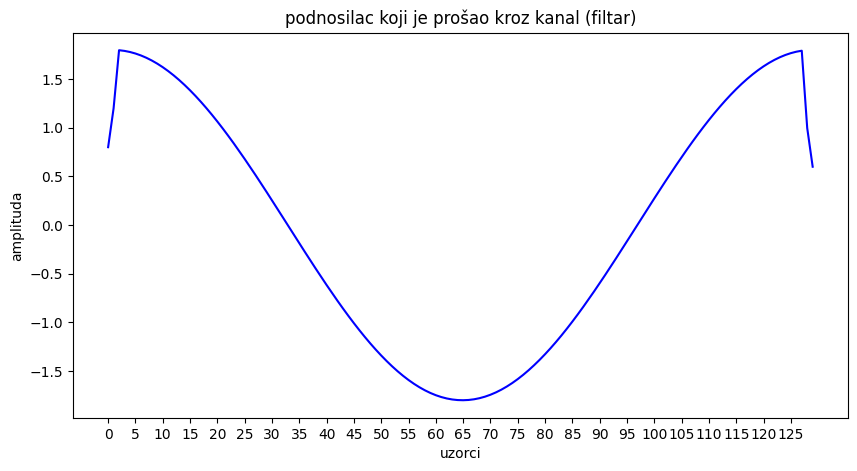

In [ ]:
h = np.array([0.8,0.4,0.6])
subc_filt_real = np.convolve(subc_real, h)

fig=plt.figure(figsize=(10,5), dpi=100)
xvals = np.arange(len(subc_filt_real))
plt.plot(subc_filt_real, 'b')

plt.title('podnosilac koji je prošao kroz kanal (filtar)')
plt.xticks(np.arange((0), max(xvals)+1, 5.0))
plt.xlabel('uzorci')
plt.ylabel('amplituda')

print(len(subc_real))
print(len(subc_filt_real))


Zadatak 6.

a) Koliko je dug signal na izlazu filtra? Napisati Python naredbu s kojom je tu informaciju moguće provjeriti.

b) Što se dogodilo nakon filtriranja?

<font color='green'> Na ulazu u filtar signal je dug 128 uzoraka, a po završetku filtriranja 130, što je za očekivati jer imamo filtar trećeg stupnja, dakle L = 3, tj L-1 = 2. Nakon filtriranja javila se netočnost krajnjih uzoraka, kao što smo i očekivali iz teorijskog uvoda.

</font>

Ciklički prefiks preslika je kraja OFDM simbola koja se dodaje na početak OFDM simbola kako bi kako bi se doskočilo prikazanim problemima. Ciklički prefiks mora biti dulji od vremenske razlike u pristizanju prve i posljednje replike signala različitih višestaznih komponenti.

S obzirom da se kanal prikazuje kao FIR filtar s trima koeficijentima, prva višestazna komponenta stiže bez kašnjenja, druga s kašnjenjem jednog uzorka, a treća s kašnjenjem dva uzorka. Moguće je uzeti ciklički prefiks duljine veće od dva.

Text(0, 0.5, 'amplituda')

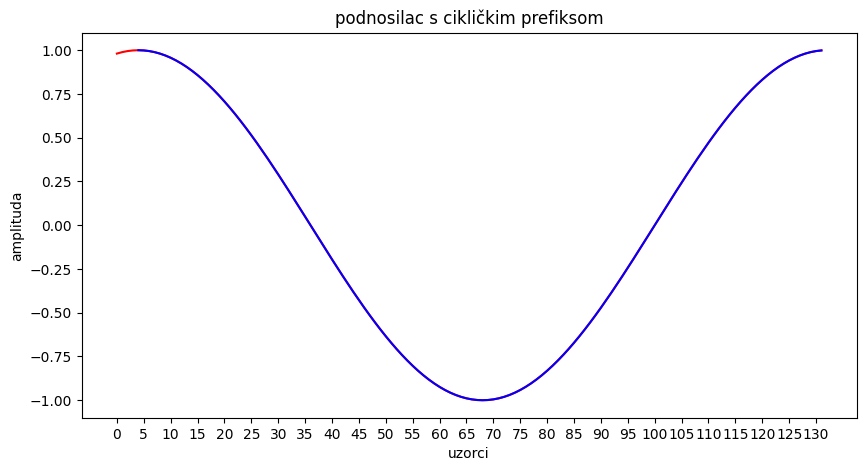

In [ ]:
cp = subc_real[124:128] # prefiks duljine 4

subc_cp = np.concatenate((cp, subc_real))

fig=plt.figure(figsize=(10,5), dpi=100)
plt.plot(subc_cp,'r')
xvals = np.arange(132)
xvals = xvals[4:132]
plt.plot(xvals,subc_cp[4:132],'b')

plt.title('podnosilac s cikličkim prefiksom')
plt.xticks(np.arange((0), max(xvals)+1, 5.0))
plt.xlabel('uzorci')
plt.ylabel('amplituda')

Zadatak 7.

Što je moguće primijetiti na spoju cikličkog prefiksa i signala, odnosno kakav je taj spoj?

<font color='green'>Obzirom na ciklički prefiks koji se koristi kao zaštitna tehnika sada više nema te nepreciznosti. Spoj CP i signala je kontinuiran.</font>

Ciklički prefiks može se dodati svakom podnosiocu zasebno - OFDM simbol u tom slučaju nastaje zbrajanjem svih tako oblikovanih podnosilaca.

Također, može se prvo napraviti IFFT kako bi se generirala suma ortogonalnih podnosilaca bez cikličkih prefiksa pa se naknadno dodati ciklički prefiks na početak simbola.

Text(0, 0.5, 'amplituda')

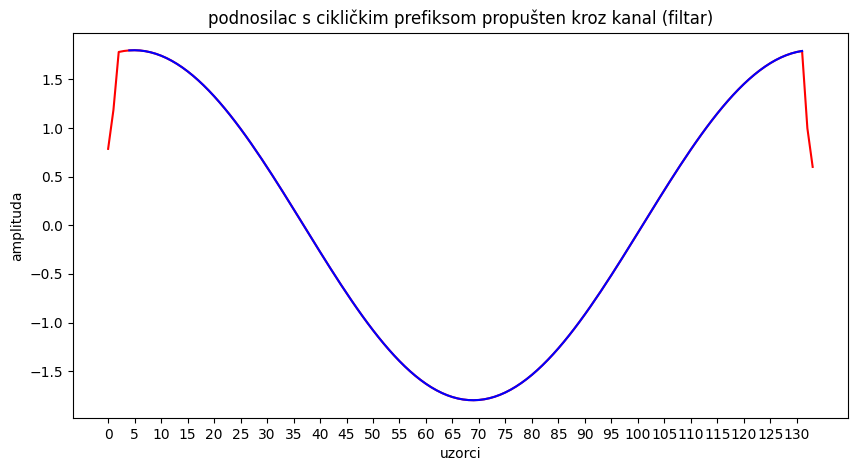

In [ ]:
subc_cp_filt = np.convolve(subc_cp, h)

fig=plt.figure(figsize=(10,5), dpi=100)
plt.plot(subc_cp_filt,'r')
xvals = np.arange(132)
xvals = xvals[4:132]
plt.plot(xvals,subc_cp_filt[4:132],'b')

plt.title('podnosilac s cikličkim prefiksom propušten kroz kanal (filtar)')
plt.xticks(np.arange((0), max(xvals)+1, 5.0))
plt.xlabel('uzorci')
plt.ylabel('amplituda')


Zadatak 8.

Koja je razlika u odnosu na sliku podnosioca koji ne sadrži ciklički prefiks i prošao je kroz kanal (`plt.title('podnosilac koji je prošao kroz kanal (filtar)')`? Zašto je pristup s cikličkim prefiksom bolji? Napomena: obratiti pažnju na broj uzoraka!

<font color='green'> Kanal jednako izobliči signal, no ovdje (s CPom) originalna inormacija (128 uzorka) ostaje netaknut, dok se u 1. slučaju (bez CP) izobličava signal od 128 uzorka koji nam nosi informaciju. </font>

### Literatura

[1] Materijali predavanja kolegija Digitalne komunikacije, Fakultet elektrotehnike i računarstva, https://www.fer.unizg.hr/predmet/digkom

[2] Materijali predavanja kolegija Mobilne komunikacije, Fakultet elektrotehnike i računarstva, https://www.fer.unizg.hr/predmet/mobkom_b

[3] https://github.com/strath-sdr/

[4] https://en.wikipedia.org/wiki/Finite_impulse_response

[5] Proakis, J.G. and Salehi, M. "Digital Communications 5th Edition", 2008. McGraw-Hill, New York
